# Pneumonia detection in X-Ray images

This project's focus was the creation of accurate classifiers using both classic Machine Learning and Deep Learning methods, for the identification of Pneumonia on X-Ray images of lungs. The dataset was provided on Kaggle ( https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia ) and consisted of 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). The Pneumonia case had a further categorization in cases caused either by virus or bacterial infection. For this project, the problem was approached as a two-class problem, concerning the identification or not of pneumonia on the test set.

* Classic ML: Three different approaches were performed. The first approach involved the application of dimensionality reduction techniques directly to the images to discern possible separation planes. The second involved the extraction of one feature and subsequent dimensionality reduction. The thrid one involved the extraction of 7 features and no ensuing dimensionality reduction. The best results were yielded by the third one. Four different dimensionality reduction techniques were tested (PCA, Truncated SVD, tSNE, UMAP) and four different classifiers (SVM, Logistic Regression, Random Forest, XGBoost). In all cases hyperparameter tuning under the Bayesian framework ensued, utilizing the Optuna package. XGBoost was the best performing classifier during the validation process (MCC score: 0.71). On the test set, SVM seemed to result in less misclassifications and better scores overall (macro averages of precision, recall, F1-score: 0.87, 0.79, 0.80, accuracy 0.83) but the results between the two were pretty close.  More details about the results and the operations performed can be found in the respective section.

* Deep Learning: Two pretrained CNN-based models (DenseNet169, MobilenetV2) were stacked together. The stacked model was trained for 20 epochs. The results of the model were superior to those of the classic ML algorithms. It achieved macro average scores for precision, recall and F1-score of  0.92, 0.89, 0.90 respectively and an accuracy score of 0.91. Only 55 (45 for the pneumonia class, 10 for the normal class) out of the 624 total test instances were misclassified, making its results far more accurate, while also showcasing an ability of managing the class imbalance. 

All in all, the Deep Learning model outperformed all classic ML models and managed to handle the class imbalance efficiently, not favoring the more abundant normal class. The pneumonia class would be more important to identify correctly in new X-Ray images in a medical setting, as wrongly classified images as normal cases could have an adverse effect for a patient that wouldn't receive pneumonia appropriate care in due time. It should be noted however that the classic ML models are more easily interpretable, which could also be of great importance in a medical setting, should their performance in correctly classifying the pneumonia class increase.

In [2]:
import numpy as np 
import pandas as pd 
import os
from pathlib import Path
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras



# Data load

In [3]:
def data_to_dataframe(image_path):
    normal_cases_dir = image_path / 'NORMAL'
    pneumonia_cases_dir = image_path / 'PNEUMONIA'
    
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    
    data = []
    
    # Go through all the normal cases and append label 1
    for img in normal_cases:
        data.append((img, 1))

    # Go through all the pneumonia cases and append label 0
    for img in pneumonia_cases:
        data.append((img, 0))
    
    data_df = pd.DataFrame(data, columns=['image', 'label'], index=None)
    
    # Shuffle the DataFrame rows
    data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return data_df

In [4]:
data_dir = Path('../input/chest-xray-pneumonia/chest_xray')

train_path = data_dir / 'train'

val_path = data_dir / 'val'

test_path = data_dir / 'test'

In [5]:
train_data = data_to_dataframe(train_path)
train_data

,image,label
0,../input/chest-xray-pneumonia/chest_xray/train...,0
1,../input/chest-xray-pneumonia/chest_xray/train...,1
2,../input/chest-xray-pneumonia/chest_xray/train...,0
3,../input/chest-xray-pneumonia/chest_xray/train...,0
4,../input/chest-xray-pneumonia/chest_xray/train...,0
...,...,...
5211,../input/chest-xray-pneumonia/chest_xray/train...,1
5212,../input/chest-xray-pneumonia/chest_xray/train...,0
5213,../input/chest-xray-pneumonia/chest_xray/train...,0
5214,../input/chest-xray-pneumonia/chest_xray/train...,0


In [6]:
val_data = data_to_dataframe(val_path)
val_data

,image,label
0,../input/chest-xray-pneumonia/chest_xray/val/N...,1
1,../input/chest-xray-pneumonia/chest_xray/val/N...,1
2,../input/chest-xray-pneumonia/chest_xray/val/N...,1
3,../input/chest-xray-pneumonia/chest_xray/val/P...,0
4,../input/chest-xray-pneumonia/chest_xray/val/P...,0
5,../input/chest-xray-pneumonia/chest_xray/val/P...,0
6,../input/chest-xray-pneumonia/chest_xray/val/P...,0
7,../input/chest-xray-pneumonia/chest_xray/val/P...,0
8,../input/chest-xray-pneumonia/chest_xray/val/N...,1
9,../input/chest-xray-pneumonia/chest_xray/val/P...,0


In [7]:
test_data = data_to_dataframe(test_path)
test_data

,image,label
0,../input/chest-xray-pneumonia/chest_xray/test/...,0
1,../input/chest-xray-pneumonia/chest_xray/test/...,0
2,../input/chest-xray-pneumonia/chest_xray/test/...,1
3,../input/chest-xray-pneumonia/chest_xray/test/...,1
4,../input/chest-xray-pneumonia/chest_xray/test/...,0
...,...,...
619,../input/chest-xray-pneumonia/chest_xray/test/...,1
620,../input/chest-xray-pneumonia/chest_xray/test/...,1
621,../input/chest-xray-pneumonia/chest_xray/test/...,0
622,../input/chest-xray-pneumonia/chest_xray/test/...,0


# Data exploration

This problem will be defined as a two class problem, where both cases of pneumonia (virus, bacteria) will be treated as one class. The other class will be that of the normal X-Ray images (no pneumonia).

In [8]:
def plot_class_labels(dataframe, label_column):
    sns.countplot(data=dataframe, x=label_column)
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Class Labels')

    # Add labels on top of bars
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.show()

In [9]:
def display_images(train_path):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
    train_path = Path(train_path)
    paths = list(train_path.iterdir())
    normal_train = Path(paths[0])
    pneumonia_train = Path(paths[1])
    rows = 0
    cols = 0
    normal_images = [str(i) for i in normal_train.iterdir()][:5]
    diseas_images = [str(i) for i in pneumonia_train.iterdir()][:5]
    
    for i in normal_images:
        img_data = cv2.imread(i)
        gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        axes[rows][cols].imshow(gray_image, cmap='gray')
        axes[rows][cols].axes.set_xticklabels([])
        axes[rows][cols].axes.set_yticklabels([])
        axes[rows][cols].axes.set_xlabel("NORMAL")
        cols += 1
    
    rows += 1
    cols = 0
    
    for i in diseas_images:
        img_data = cv2.imread(i)
        gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        axes[rows][cols].imshow(gray_image, cmap='gray')
        axes[rows][cols].axes.set_xticklabels([])
        axes[rows][cols].axes.set_yticklabels([])
        axes[rows][cols].axes.set_xlabel("PNEUMONIA")
        cols += 1
    
    fig.suptitle("IMAGES")
    plt.show()


Train set


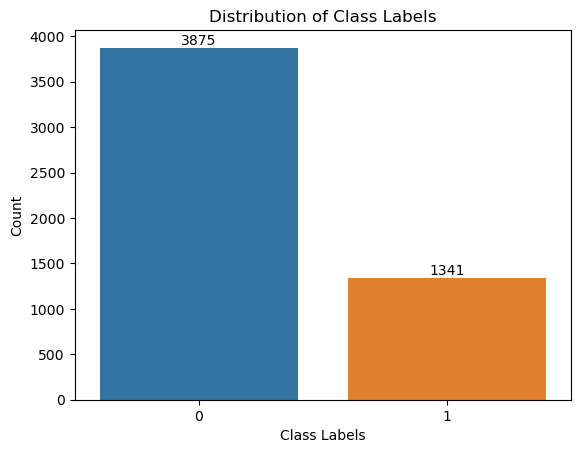

Validation set


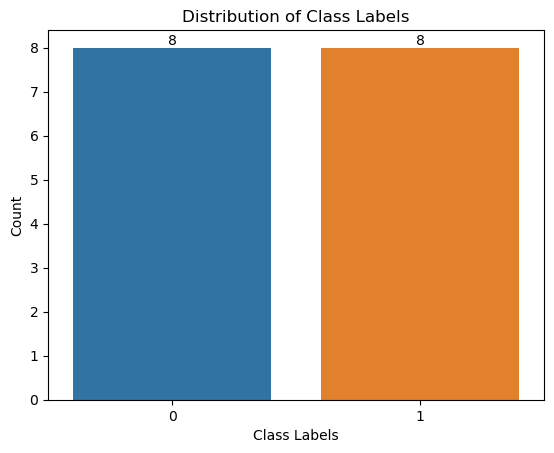

Test set


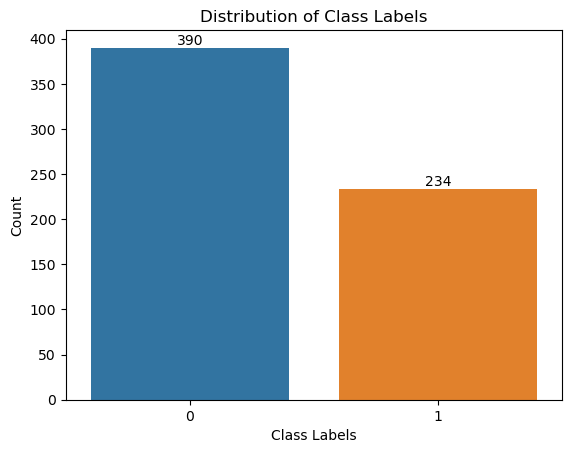

In [10]:
print('Train set')
plot_class_labels(train_data, 'label')

print('Validation set')
plot_class_labels(val_data, 'label')

print('Test set')
plot_class_labels(test_data, 'label')

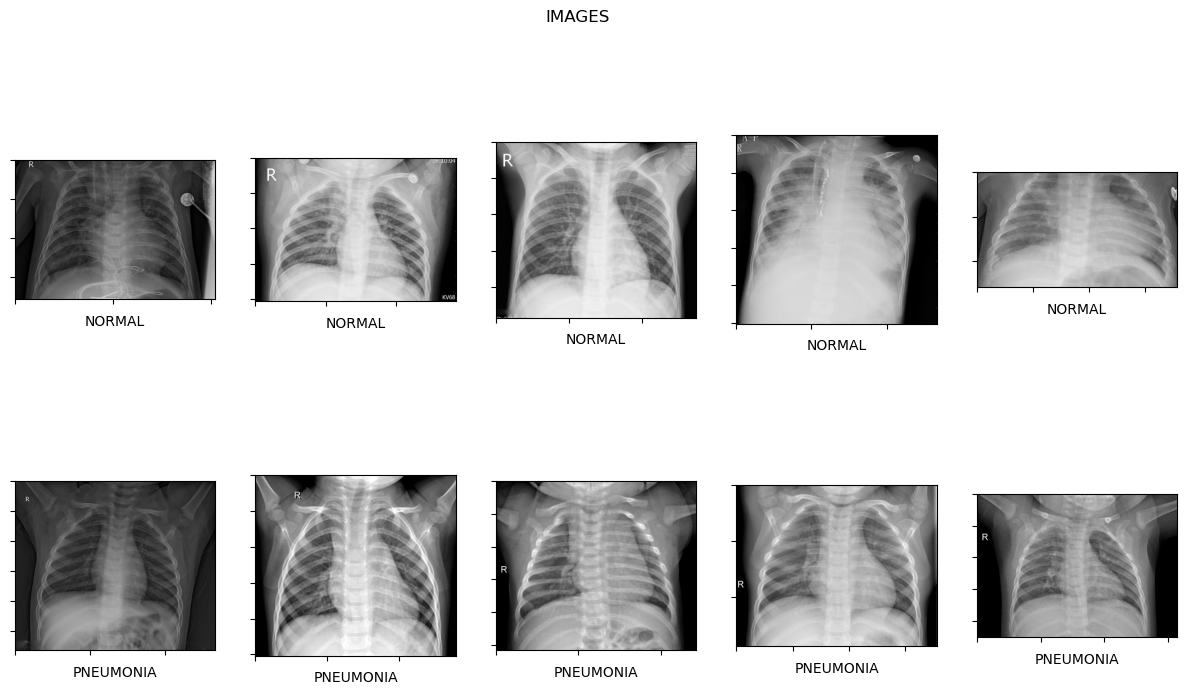

In [10]:
display_images(train_path)

Since the validation set is so small and doesn't include the natural classes proportions presented in the train and test set, it isn't considered appropriate for use in the validation process, as it would lead to inaccurate results. To remedy this problem a new validation set is created by splitting a part of the train set. During the split the dataset is suffled and stratify is also used to retain the classes proportions of the train set.

In [11]:
train_data = pd.concat([train_data, val_data], ignore_index=True)
print(len(train_data.index.unique()))


5232


In [12]:
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify=train_data['label'], shuffle=True, random_state=42)

In [13]:
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 4447
Validation set size: 785
Test set size: 624


In [14]:
print(type(train_data['image'].iloc[0]))

<class 'pathlib.PosixPath'>


The histograms of the first 10 images of the train set are visualized below to get a sense of the similarity of the data. Label 0 corresponds to normal, label 1 to pneumonia. It can be seen that normal images usually have higher frequencies but so do some pneumonia images. However, most of the latter seem to have lower frequency rates, therefore, this attribute may be something that can be exploited in the separation of the classes.

In [15]:
def plot_ordered_histograms(dataframe, image_column, label_column):
    ordered_df = dataframe.copy()
    ordered_df = ordered_df.sort_values(label_column)
    ordered_images = ordered_df[image_column].values
    ordered_labels = ordered_df[label_column].values

    num_images = len(ordered_images)
    num_rows = 2
    num_cols = 5

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    # Plot histograms of first five images in the first row
    for i in range(num_cols):
        image = cv2.imread(str(ordered_images[i]))
        histogram = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256])
        ax = axes[0][i]
        label = ordered_labels[i]
        ax.plot(histogram)
        ax.set_xlim([0, 256])
        ax.set_title(f"Image {i+1} (Class {label})")
        ax.set_xlabel("Pixel Value")
        ax.set_ylabel("Frequency")

    # Plot histograms of last five images in the second row
    for i in range(num_cols):
        image = cv2.imread(str(ordered_images[num_images - num_cols + i]))
        histogram = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256])
        ax = axes[1][i]
        label = ordered_labels[num_images - num_cols + i]
        ax.plot(histogram)
        ax.set_xlim([0, 256])
        ax.set_title(f"Image {num_images - num_cols + i + 1} (Class {label})")
        ax.set_xlabel("Pixel Value")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


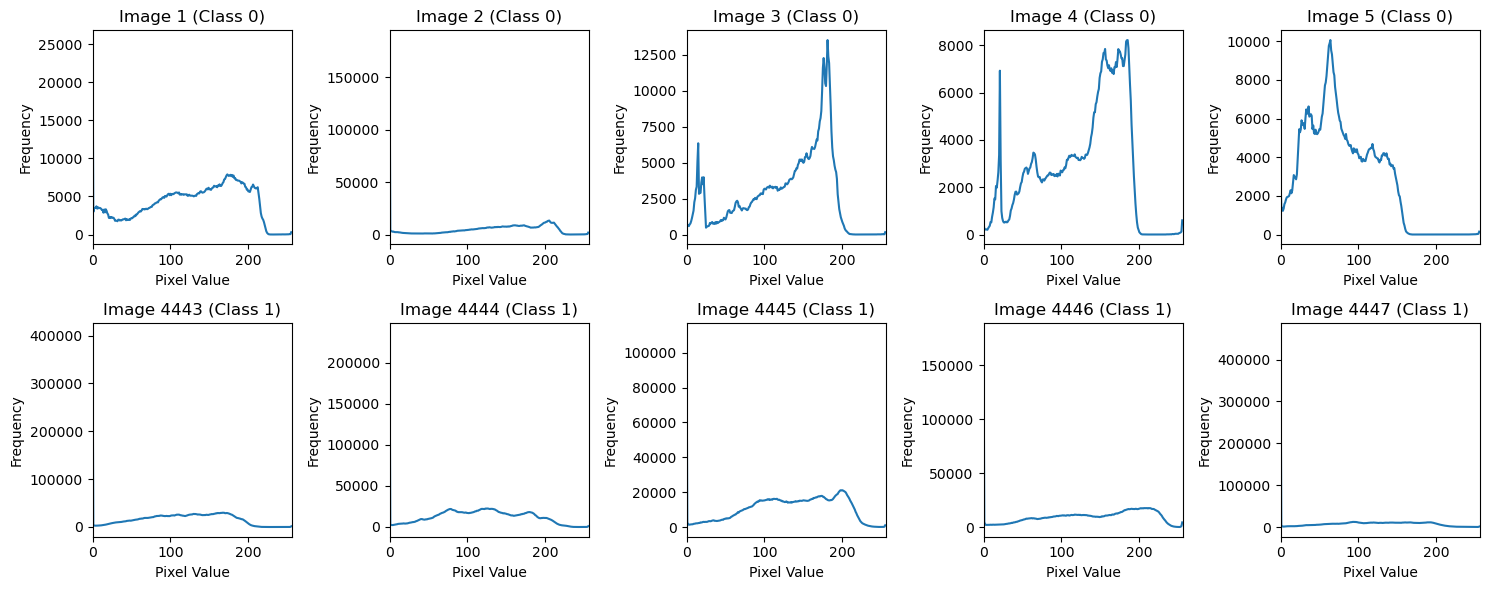

In [16]:
plot_ordered_histograms(train_data, 'image', 'label')

# Classic Machine Learning

The classic ML experiments were performed using 4 different classifiers, namely SVM (linear kernel), Logistic Regression, Random Forest and XGBoost. It was also performed under three approaches. The Optuna package was used for hyperparameter tuning under the Bayesian network. The performance of each algorithm was tested on the validation set.

The first approach involved the dimensionality reduction of the data space, without extracting any features. SVD, tSNE and UMAP were utilized, however, none of them seemed to offer a good-enough separation of the data space and thus this approach was abandoned.

The second approach involved the extraction of the intensity histogram values for each image (a sample of which is depicted above) and their subsequent dimensionality reduction. The idea behind this approach was to use the intensity histogram values as an informative feature of the images, since it seemed to offer some good differentiation between normal and pneumonia cases and then reduce the dimensionality space to the first components. Four different dimensionality reduction techniques were applied (PCA, SVD, tSNE, UMAP) and judging by the visualization of the 2D data space, UMAP was chosen as it seemed to offer the best space separation between the two classes. All algorithms were trained, however their results weren't quite accurate. SVM seemed to give the best results, however, all metrics were still low (MCC: 0.57) and a large proportion of the samples were misclassified. In the end, this approach was abandoned as well.

The third approach involved more intense feature extraction. Seven features were extracted from the images. Those were variance, mean, standard deviation, skew, kurtosis, entropy, and local binary pattern (LBP). No dimensionality reduction ensued. Hyperparameter tuning was done again using the Optuna framework. The results of this approach were much better than the ones before. Through testing on the validation set XGBoost proved to be the best performing model (MCC: 0.71), followed in order by Random Forest, SVM and Logistic Regression. Random Forest was a close second and also inherently offers the capability of comparing the importance of each feature, therefore it could be considered if the framework required increased interpretability, which is usually the setting in a medical environment. The results were different on the test set. XGBoost gave adequate scores for all metrics, however almost 50% of the instances of the positive class (pneuomonia) were misclassified. This creates a problem as it would be desired for the positive class to not have such a misclassification rate, which in a model deployment scenario could lead to false predictions that would have adversary effects on the patients (i.e. the late discovery of pneumonia). The same applied for Random Forest. On these unseen data it seemed that the simpler models generalized better. LR gave interestingly much better results than the ones for the validation set and SVM was the most accurate classifier of them all, misclassifying the least samples (94 out of 234) and achieving higher scores in all metrics. Nontheless, the issue of the high misclassification rate of the positive class remained. This issue could further be adressed by applying class weights or by using techniques like oversampling of the negative class using SMOTE, however, they are not explored at this stage and are left open for future research. The next focus of the project is the implementation of Deep Learning methods to try and surpass the classic ML results and offer better classification results.

## ML Approach 1 (Using only dimensionality reduction)

In this approach the resized images were simply reduced in dimensions to observe whether there existed clearly separated boundaries between the first components that could have been exploited to separate the classes. No such separation was found, therefore this approach was abandoned.

### Truncated SVD

In [ ]:
def apply_svd_to_resized_images(dataframe, image_column, label_column, n_components, scree_plot=None):
    images = dataframe[image_column].values
    labels = dataframe[label_column].values

    flattened_images = []
    for image in images:
        flattened_image = image.reshape(-1)
        flattened_images.append(flattened_image)

    X = np.array(flattened_images)

    # Apply Singular Value Decomposition (SVD)
    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X)
    
    if scree_plot == 1:
        # Extract the singular values
        singular_values = svd.singular_values_

        # Compute the explained variance ratio
        explained_variance_ratio = np.square(singular_values) / np.square(singular_values).sum()

        # Plot the scree plot with explained variance on the y-axis
        plt.figure(figsize=(10, 8))
        plt.plot(range(1, len(singular_values) + 1), explained_variance_ratio, 'bo-', label='Explained Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance')
        plt.title('Scree Plot')
        plt.legend()
        plt.grid(True)
        plt.savefig('svd_scree_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.savefig('svd_scree_plot.pdf', dpi=300, facecolor='white')
        plt.show()

    return X_svd, labels

In [ ]:
def visualize_svd_space(X_svd, labels):
    plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='Set1')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.colorbar()
    plt.show()

According to the following scree plot most of the variance of the dataset can be explained by the first two components of SVD. Therefore the dimensionality reduction will be performed by using those.

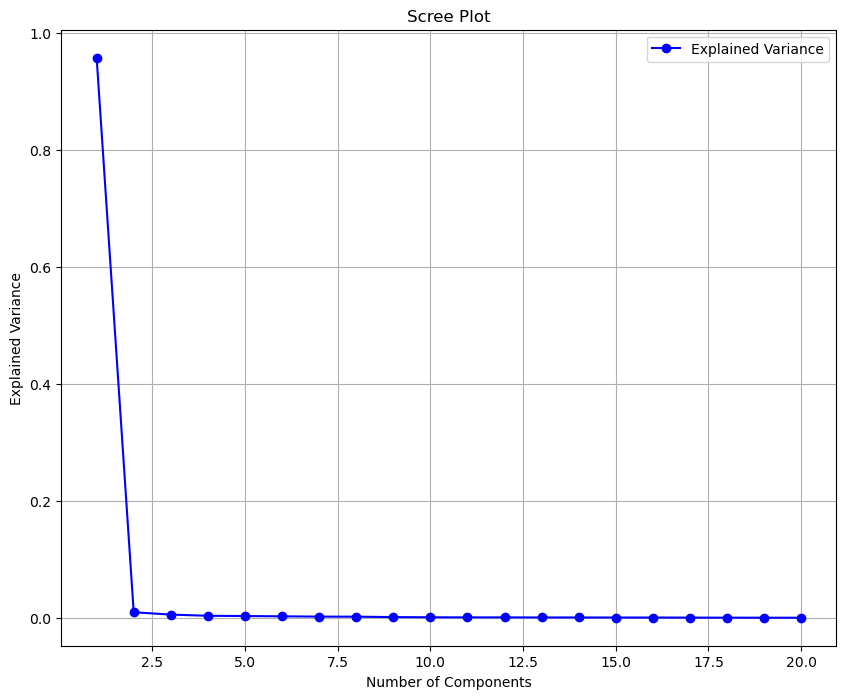

(array([[56243.66000757, -2237.79340655, -8927.35794092, ...,
          1373.55601562, -1412.44399062,  -625.31773811],
        [51616.35460787, -6857.45848169, -3461.59967641, ...,
          1139.3188057 ,  -278.27180059,  -115.75832836],
        [70475.18858186, 13445.52973741,  4780.74830808, ...,
          1329.16404006,   140.01677921,  -759.6401118 ],
        ...,
        [66823.11153767, 13166.73202651,  1412.6252087 , ...,
          1224.471999  ,  -717.2497235 , -1240.32262183],
        [53764.79838606,  -230.49632821,  5903.08130392, ...,
         -2284.78735879,  -938.0404939 ,  -573.44891926],
        [50533.60388677,  -811.06479441, -1848.54962315, ...,
          -520.43801603,  -328.83252736,   953.96290969]]),
 array([0, 0, 1, ..., 1, 1, 1]))

In [ ]:
apply_svd_to_resized_images(resized_data, 'image', 'label', n_components=20, scree_plot=1)

In [ ]:
X_train_svd, train_labels = apply_svd_to_resized_images(resized_data, 'image', 'label', n_components=2)

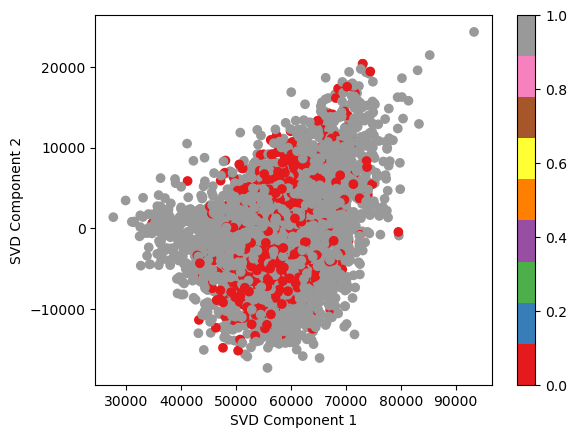

In [ ]:
visualize_svd_space(X_train_svd, train_labels)

### tSNE

In [ ]:


def apply_tsne_to_resized_images(dataframe, image_column, label_column, n_components, perplexity=30, random_state=None):
    images = dataframe[image_column].values
    labels = dataframe[label_column].values

    flattened_images = []
    for image in images:
        flattened_image = image.reshape(-1)
        flattened_images.append(flattened_image)

    X = np.array(flattened_images)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    return X_tsne, labels

In [ ]:
def visualize_tsne_space(X_tsne, labels):
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    plt.xlabel('tSNE Component 1')
    plt.ylabel('tSNE Component 2')
    plt.colorbar()
    plt.show()

In [ ]:
X_train_tsne, labels = apply_tsne_to_resized_images(resized_data, 'image', 'label', n_components=2, perplexity=30, random_state=42)

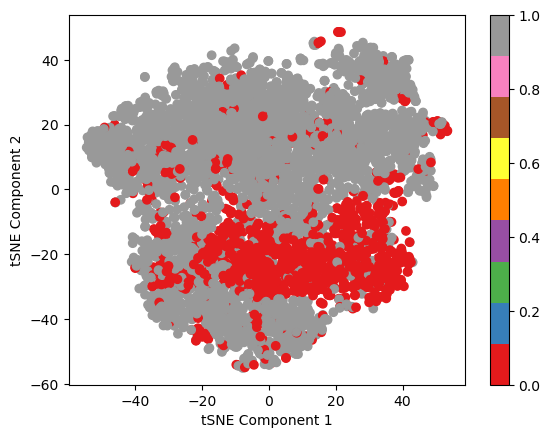

In [ ]:
visualize_tsne_space(X_train_tsne, labels)

### UMAP

In [ ]:
def apply_umap_to_resized_images(dataframe, image_column, label_column, n_components, n_neighbors=5, min_dist=0.1, random_state=42):
    images = dataframe[image_column].values
    labels = dataframe[label_column].values

    flattened_images = []
    for image in images:
        flattened_image = image.reshape(-1)
        flattened_images.append(flattened_image)

    X = np.array(flattened_images)

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    X_umap = reducer.fit_transform(X)

    return X_umap, labels

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [ ]:
def visualize_umap_space(X_umap, labels):
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Set1')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.colorbar()
    plt.show()

In [ ]:
X_train_umap, labels = apply_umap_to_resized_images(resized_data, 'image', 'label', n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)

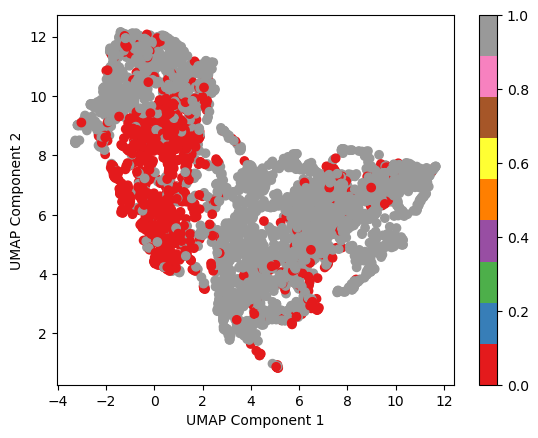

In [ ]:
visualize_umap_space(X_train_umap, labels)

## ML Approach 2

In this approach a single feature was extracted (intensity histogram values) and then four different dimensionality techniques were tested (PCA, Truncated SVD, tSNE, UMAP). UMAP seemed to offer the best space separation between the classes, therefore it was chosen to reduce the data space and after that the classification process ensued by comparing the performance of four algorithms on the validation set (SVM-linear kernel, Logistic Regression, Random Forest, XGBoost). This process didn't offer promising results so it was abandoned as well.

### Preprocessing

First all images need to be brought to the same size. They will be resized to 224x224.

In [17]:
def resize_images(dataframe, image_column, target_size):
    resized_images = []

    for image_path in dataframe[image_column]:
        image = cv2.imread(str(image_path))
        resized_image = cv2.resize(image, target_size)
        resized_images.append(resized_image)

    resized_dataframe = dataframe.copy()
    resized_dataframe[image_column] = resized_images

    return resized_dataframe

In [18]:
resized_data = resize_images(train_data, 'image', target_size=(256, 256))

In [19]:
resized_data

,image,label
493,"[[[4, 4, 4], [7, 7, 7], [11, 11, 11], [16, 16,...",0
168,"[[[17, 17, 17], [26, 26, 26], [19, 19, 19], [2...",0
5176,"[[[55, 55, 55], [59, 59, 59], [60, 60, 60], [6...",0
3210,"[[[56, 56, 56], [56, 56, 56], [56, 56, 56], [5...",0
4271,"[[[6, 6, 6], [6, 6, 6], [6, 6, 6], [8, 8, 8], ...",0
...,...,...
3544,"[[[86, 86, 86], [75, 75, 75], [88, 88, 88], [7...",0
1370,"[[[39, 39, 39], [55, 55, 55], [84, 84, 84], [7...",0
3752,"[[[46, 46, 46], [47, 47, 47], [51, 51, 51], [4...",0
381,"[[[69, 69, 69], [68, 68, 68], [72, 72, 72], [6...",0


### Feature extraction

Feature extraction was performed by using dimensionality reduction to reduce the number of features to the dimensions that explain the most variance of the data. Three different dimensionality reduction techniques were applied, namely Truncated SVD, tSNE and UMAP. From the visualization of the 2D space it seems that the data of the two classes are not linearly separable. This makes it harder to separate using classical Machine Learning methods, as the model needs to capture very complex decision boundaries to accurately classify the data points. The overlapping or intertwined nature of the classes in the SVD space suggests that there may be significant overlap or dependencies in the underlying feature space. However, it seems that UMAP results in the clearest space differentiation of the three techniques and even though there are samples of each class that are inside the wrong cluster, most instances of the two classes are separated. 

### Using feature extraction and dimensionality reduction

In [20]:
def extract_intensity_histograms(dataframe, image_column, label_column):
    images = dataframe[image_column].values
    labels = dataframe[label_column].values

    histograms = []
    for image in images:
        # Flatten the image and convert it to a NumPy array
        image_np = np.array(image).flatten()

        # Compute the intensity histogram
        hist, _ = np.histogram(image_np, bins=256, range=[0, 256])
        histograms.append(hist)

    # Create a new DataFrame with histograms and labels
    output_dataframe = pd.DataFrame({
        'histograms': histograms,
        'labels': labels
    })

    return output_dataframe

In [98]:
train_hists = extract_intensity_histograms(resized_data, 'image', 'label')
train_hists

,histograms,labels
0,"[4638, 612, 696, 762, 681, 621, 723, 621, 645,...",0
1,"[879, 1929, 1230, 795, 840, 852, 501, 387, 414...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 9, 15,...",0
3,"[11181, 1056, 714, 660, 633, 576, 528, 501, 43...",0
4,"[26745, 789, 819, 606, 624, 567, 525, 522, 486...",0
...,...,...
4442,"[561, 432, 309, 279, 339, 336, 396, 486, 471, ...",0
4443,"[12, 21, 39, 42, 24, 33, 48, 84, 111, 126, 138...",0
4444,"[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 3, 0, ...",0
4445,"[114, 102, 78, 96, 72, 138, 126, 138, 201, 288...",0


#### PCA

In [154]:
from sklearn.decomposition import PCA

def apply_pca_to_histograms(dataframe, histogram_column, label_column, n_components, scree_plot=None):
    histograms = dataframe[histogram_column].values
    labels = dataframe[label_column].values

    # Extract histogram values as features
    X = np.vstack(histograms)

    # Apply Principal Component Analysis (PCA)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    if scree_plot == 1:
        # Extract the explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_

        # Plot the scree plot with explained variance on the y-axis
        plt.figure(figsize=(10, 8))
        plt.plot(range(1, n_components + 1), explained_variance_ratio, 'bo-', label='Explained Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance')
        plt.title('Scree Plot')
        plt.legend()
        plt.grid(True)
        plt.savefig('pca_scree_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.savefig('pca_scree_plot.pdf', dpi=300, facecolor='white')
        plt.show()

    return X_pca, labels

In [156]:
def visualize_pca_space(X_pca, labels):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

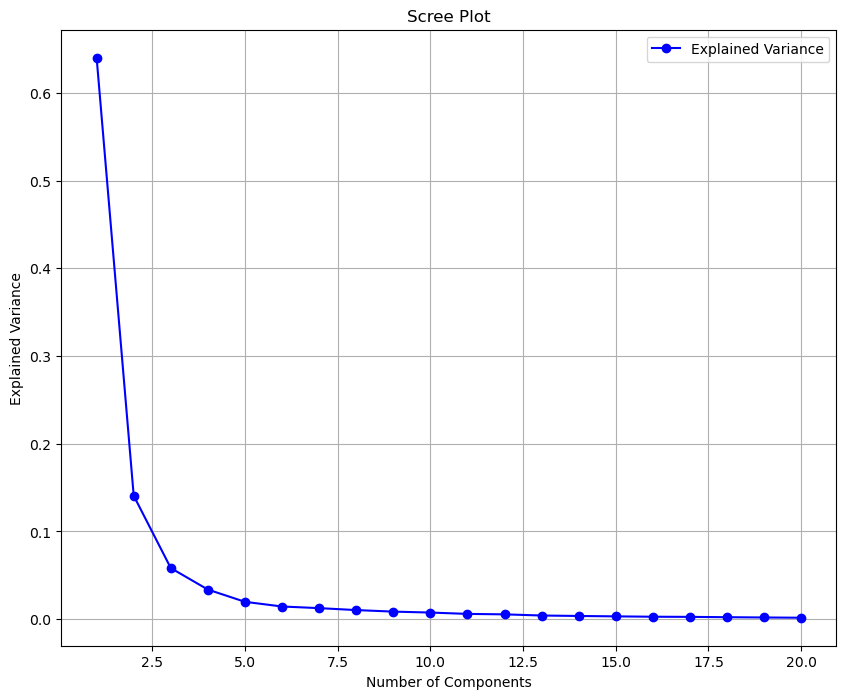

(array([[ -4547.0398246 ,    634.74708902,   2042.65831697, ...,
           -326.61825902,    -49.01269568,    -92.34389263],
        [ -7668.27733579,   5603.21155846,   6883.7052348 , ...,
            815.97505394,    592.24637474,   -449.47192936],
        [-10011.37833729,   7425.79297861,  -4966.22934184, ...,
           -679.44053083,   -394.89314798,   -723.10060637],
        ...,
        [ -9942.47160652,  15793.23433696,    415.68032474, ...,
            335.81518942,   -948.73638634,    804.53815919],
        [-10116.60237299,  13530.04645166,  -4473.77512595, ...,
            244.87448454,     29.72941739,   -180.01892609],
        [ -7358.25280534,   4059.46708514,   6765.73266575, ...,
           -488.68164358,    407.45937472,    508.62256334]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [155]:
apply_pca_to_histograms(train_hists, 'histograms', 'labels', n_components=20, scree_plot=1)

In [157]:
X_train_pca, y_pca = apply_pca_to_histograms(train_hists, 'histograms', 'labels', n_components=2)

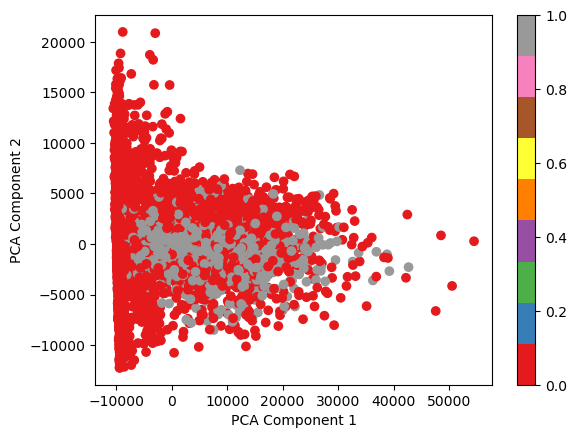

In [158]:
visualize_pca_space(X_train_pca, y_pca)

#### Truncated SVD

In [22]:
def apply_svd_to_histograms(dataframe, histogram_column, label_column, n_components, scree_plot=None):
    histograms = dataframe[histogram_column].values
    labels = dataframe[label_column].values

    # Extract histogram values as features
    X = np.vstack(histograms)

    # Apply Singular Value Decomposition (SVD)
    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X)
    
    if scree_plot == 1:
        # Extract the singular values
        singular_values = svd.singular_values_

        # Compute the explained variance ratio
        explained_variance_ratio = np.square(singular_values) / np.square(singular_values).sum()

        # Plot the scree plot with explained variance on the y-axis
        plt.figure(figsize=(10, 8))
        plt.plot(range(1, len(singular_values) + 1), explained_variance_ratio, 'bo-', label='Explained Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance')
        plt.title('Scree Plot')
        plt.legend()
        plt.grid(True)
        plt.savefig('svd_scree_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.savefig('svd_scree_plot.pdf', dpi=300, facecolor='white')
        plt.show()

    return X_svd, labels



In [23]:
def visualize_svd_space(X_svd, labels):
    plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='Set1')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.colorbar()
    plt.show()

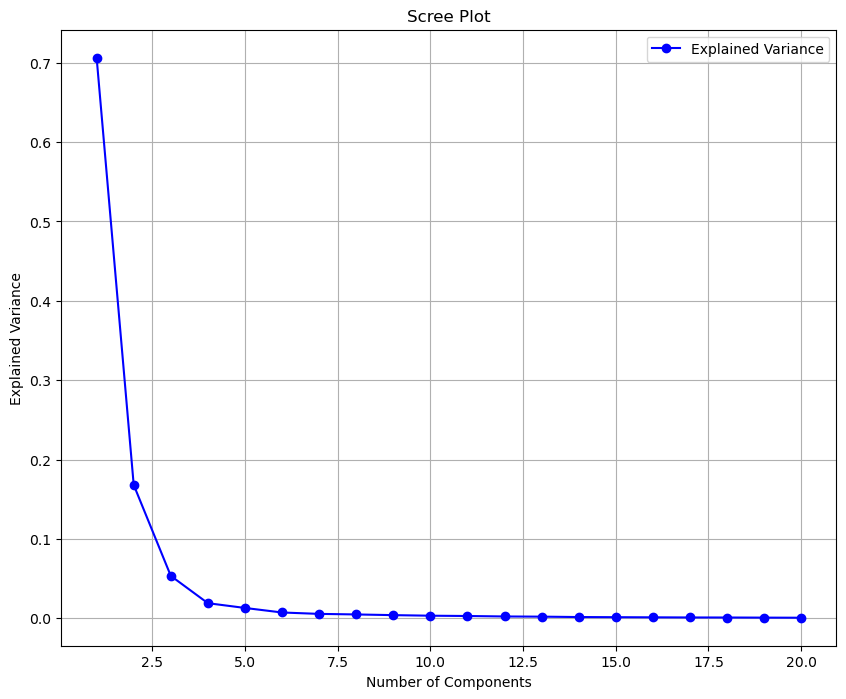

(array([[ 12752.83279843,  -6231.46793217,    473.14613804, ...,
             23.74975602,   -330.51796455,    -49.76822105],
        [  8309.72241894,  -6556.97061121,   6092.60309616, ...,
           -717.99392569,    841.75066926,    593.69527624],
        [ 11867.75465226, -13068.1383848 ,   6380.45659336, ...,
           -642.08059682,   -674.14687247,   -395.62409789],
        ...,
        [ 11612.38595617, -12894.60490988,  15065.19902732, ...,
           -355.65934919,    338.75170513,   -947.91232688],
        [ 12470.17967443, -13904.23582368,  12411.74468939, ...,
            -32.72419213,    241.21226049,     29.36051037],
        [  9224.423218  ,  -6882.88947225,   4394.41472148, ...,
          -1354.37635814,   -473.21243075,    408.39825523]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [24]:
apply_svd_to_histograms(train_hists, 'histograms', 'labels', n_components=20, scree_plot=1)

In [99]:
X_train_svd, labels = apply_svd_to_histograms(train_hists, 'histograms', 'labels', n_components=2)

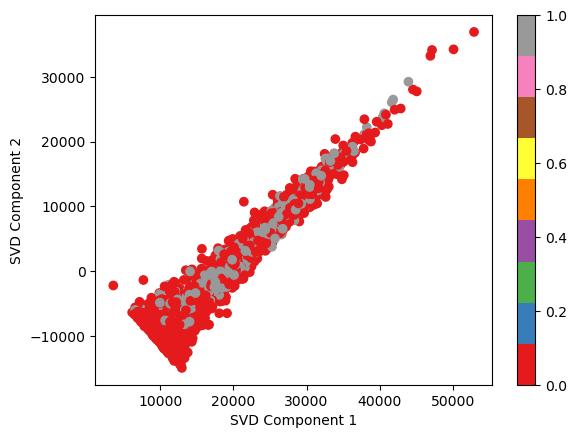

In [100]:
visualize_svd_space(X_train_svd, labels)

#### tSNE

In [83]:
def apply_tsne_to_histograms(dataframe, histogram_column, label_column, n_components, perplexity=30, random_state=None):
    histograms = dataframe[histogram_column].values
    labels = dataframe[label_column].values

    # Convert list of histograms to a 2D array
    X = np.vstack(histograms)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    return X_tsne, labels

In [84]:
def visualize_tsne_space(X_tsne, labels):
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    plt.xlabel('tSNE Component 1')
    plt.ylabel('tSNE Component 2')
    plt.colorbar()
    plt.show()

In [101]:
X_train_tsne, labels = apply_tsne_to_histograms(train_hists, 'histograms', 'labels', n_components=2, perplexity=30, random_state=42)

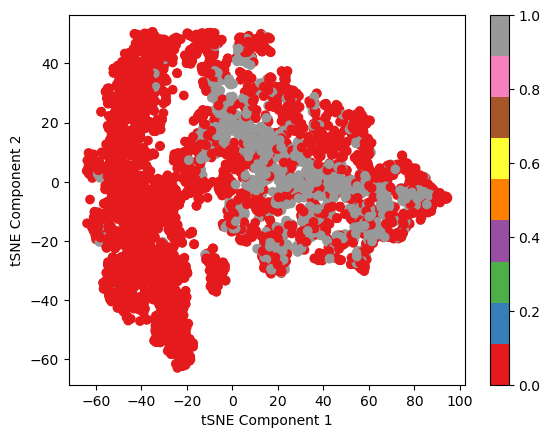

In [102]:
visualize_tsne_space(X_train_tsne, labels)

#### UMAP

In [25]:
def apply_umap_to_histograms(dataframe, histogram_column, label_column, n_components, n_neighbors=5, min_dist=0.1, random_state=42):
    histograms = dataframe[histogram_column].values
    labels = dataframe[label_column].values

    # Convert histogram values to a 2D array
    X = np.vstack(histograms)

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    X_umap = reducer.fit_transform(X)

    return X_umap, labels


In [26]:
def visualize_umap_space(X_umap, labels):
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Set1')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.colorbar()
    plt.show()

In [103]:
X_train_umap, labels = apply_umap_to_histograms(train_hists, 'histograms', 'labels', n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)

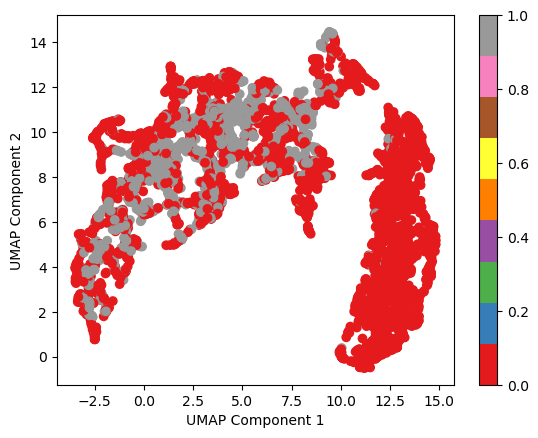

In [104]:
visualize_umap_space(X_train_umap, labels)

### ML algorithms

Appropriate classifiers need to be applied to the dimensionaly reduced space to learn to separate the data appropriately. Three algorithms were tested, namely Logistic Regression, SVM (RBF kernel) and XGBoost. They were trained on the training set and evaluated on the validation set to get an estimate of their performance against each other. Their performance was estimated utilizing three appropriate for class imbalance metrics, namely Matthews Correlation Coefficient (MCC), Balanced Accuracy and F1-score. MCC was chosen as the primary metric of comparison and therefore the "winner" classifier was the one that achieved higher score in that. That "winner" classifier was retrained on the training set and tested on the test set to get an estimate of its generalization ability to unseen data. The Optuna package was utilized for hyperparameter tuning under the Bayesian framework.

In [60]:
resized_val_data = resize_images(val_data, 'image', target_size=(256, 256))

In [61]:
val_hists = extract_intensity_histograms(resized_val_data, 'image', 'label')
val_hists

,histograms,labels
0,"[765, 705, 498, 537, 498, 624, 663, 864, 834, ...",0
1,"[14274, 180, 114, 114, 138, 135, 126, 123, 123...",1
2,"[2355, 243, 141, 126, 132, 141, 141, 117, 129,...",0
3,"[9258, 345, 252, 150, 156, 144, 111, 120, 102,...",0
4,"[19824, 585, 300, 270, 243, 285, 264, 282, 282...",1
...,...,...
780,"[750, 534, 492, 336, 474, 531, 447, 561, 633, ...",0
781,"[14994, 771, 624, 729, 765, 726, 387, 174, 159...",1
782,"[360, 414, 483, 459, 660, 801, 834, 981, 1299,...",0
783,"[27, 183, 1407, 5874, 8796, 4479, 1572, 267, 1...",0


In [62]:
X_val_umap, y_val = apply_umap_to_histograms(val_hists, 'histograms', 'labels', n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)

### SVM

In [65]:
import optuna
from optuna.samplers import TPESampler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [195]:
def objective_svm(trial, X, y):
    # Define the search space for hyperparameters
    c_svm = trial.suggest_float('c_svm', 0.001, 1, log=True)
    gamma_svm = trial.suggest_float('gamma_svm', 0.001, 1, log=True)

    # Create the Random Forest Classifier with the suggested hyperparameters
    seed = 42
    clf = SVC(kernel='linear', gamma=gamma_svm, C=c_svm, random_state=seed, max_iter=10000)

    mcc_scorer = make_scorer(matthews_corrcoef)

    if trial.should_prune():
        raise optuna.TrialPruned()

    # Perform 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=mcc_scorer)

    # Return the mean accuracy score as the objective value to be maximized
    return scores.mean()

In [118]:
def optimize_hyperparameters(X, y):
    final_objective = lambda trial: objective_svm(trial, X, y)
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(final_objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

    best_params = study.best_params
    best_value = study.best_value

    print("Best Hyperparameters:", best_params)
    print("Best Value:", best_value)

    return best_params, best_value

In [63]:
def test_model(model, X_test, y_test):

    predictions = model.predict(X_test)

    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Create the directory if it doesn't exist
    directory = 'classification_results'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the plot with unique file names
    file_name = 'confusion_matrix'
    save_path_png = os.path.join(directory, file_name + '.png')
    save_path_pdf = os.path.join(directory, file_name + '.pdf')

    # Check if the file already exists
    counter = 1
    while os.path.exists(save_path_png) or os.path.exists(save_path_pdf):
        file_name += '_' + str(counter)
        save_path_png = os.path.join(directory, file_name + '.png')
        save_path_pdf = os.path.join(directory, file_name + '.pdf')
        counter += 1

    # Save the plot
    plt.savefig(save_path_png, dpi=300, bbox_inches='tight')
    plt.savefig(save_path_pdf, dpi=300)
    plt.show()

    # Generate the classification report
    report = classification_report(y_test, predictions)

    print("Classification Report:")
    print(report)

In [194]:
def build_svm_model(X, y, best_params):
    seed = 42
    svm_model = SVC(
            kernel='linear',
            gamma=best_params['gamma_svm'],
            C=best_params['c_svm'],
            random_state=seed,
            max_iter=1000
        )

    svm_model.fit(X, y)
    
    return svm_model

In [120]:
svm_best_params, svm_best_value = optimize_hyperparameters(X_train_umap, labels)

[I 2023-07-07 20:53:57,621] A new study created in memory with name: no-name-cb9ba986-e025-40a6-9054-e6b4f70369b8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 20:54:00,785] Trial 0 finished with value: 0.4014822297850766 and parameters: {'c_svm': 0.9502908789663882, 'gamma_svm': 0.014416001885696096}. Best is trial 0 with value: 0.4014822297850766.
[I 2023-07-07 20:54:00,824] Trial 2 finished with value: 0.18458738410083636 and parameters: {'c_svm': 0.05000541321060345, 'gamma_svm': 0.04364398011504615}. Best is trial 0 with value: 0.4014822297850766.
[I 2023-07-07 20:54:00,922] Trial 1 finished with value: 0.278695347995417 and parameters: {'c_svm': 0.026570046920769815, 'gamma_svm': 0.260129916288985}. Best is trial 0 with value: 0.4014822297850766.
[I 2023-07-07 20:54:00,948] Trial 3 finished with value: 0.0 and parameters: {'c_svm': 0.653459162623573, 'gamma_svm': 0.0012433761515633392}. Best is trial 0 with value: 0.4014822297850766.
[I 2023-07-07 20:54:03,918] Trial 5 finished with value: 0.0 and parameters: {'c_svm': 0.008007053802109353, 'gamma_svm': 0.0028902677619403266}. Best is trial 0 with value: 0.4014822297850766

In [126]:
svm_model = build_svm_model(X_train_umap, labels, svm_best_params)
svm_model

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.9839744652596335, gamma=0.9965069589779767, kernel='linear',
    max_iter=1000, random_state=42)

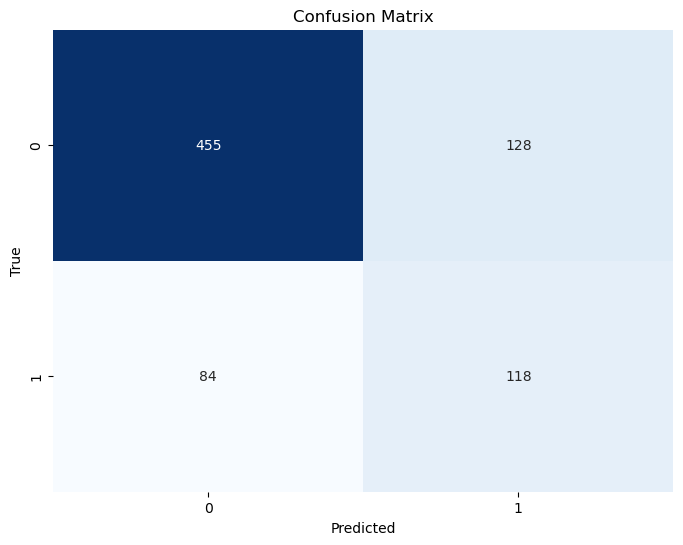

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       583
           1       0.48      0.58      0.53       202

    accuracy                           0.73       785
   macro avg       0.66      0.68      0.67       785
weighted avg       0.75      0.73      0.74       785



In [127]:
test_model(svm_model, X_val_umap, y_val)

### Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression

def objective_lr(trial, X, y):
    # Define the search space for hyperparameters
    c_lr = trial.suggest_float('c_lr', 0.001, 1, log=True)

    # Create the Logistic Regression classifier with the suggested hyperparameters
    seed = 42
    clf = LogisticRegression(C=c_lr, random_state=seed, max_iter=10000)

    mcc_scorer = make_scorer(matthews_corrcoef)

    if trial.should_prune():
        raise optuna.TrialPruned()

    # Perform 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=mcc_scorer)

    # Return the mean accuracy score as the objective value to be maximized
    return scores.mean()


In [129]:
def optimize_hyperparameters_lr(X, y):
    final_objective = lambda trial: objective_lr(trial, X, y)
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(final_objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

    best_params = study.best_params
    best_value = study.best_value

    print("Best Hyperparameters:", best_params)
    print("Best Value:", best_value)

    return best_params, best_value

In [106]:
def build_lr_model(X, y, best_params):
    seed = 42
    lr_model = LogisticRegression(
            penalty='l2',
            C=best_params['c_lr'],
            random_state=seed,
            max_iter=1000
        )

    lr_model.fit(X, y)
    
    return lr_model

In [130]:
lr_best_params, lr_best_value = optimize_hyperparameters_lr(X_train_umap, labels)

[I 2023-07-07 20:56:44,460] A new study created in memory with name: no-name-5b91c540-9771-426e-a937-3f67c867f713


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 20:56:44,721] Trial 1 finished with value: 0.08216678401929231 and parameters: {'c_lr': 0.7281111789445539}. Best is trial 1 with value: 0.08216678401929231.
[I 2023-07-07 20:56:44,739] Trial 0 finished with value: 0.08202851128880036 and parameters: {'c_lr': 0.04847797733620116}. Best is trial 1 with value: 0.08216678401929231.
[I 2023-07-07 20:56:44,822] Trial 2 finished with value: 0.07882139721616652 and parameters: {'c_lr': 0.018749357125304313}. Best is trial 1 with value: 0.08216678401929231.
[I 2023-07-07 20:56:44,838] Trial 3 finished with value: 0.050585959510287014 and parameters: {'c_lr': 0.0023060900738301757}. Best is trial 1 with value: 0.08216678401929231.
[I 2023-07-07 20:56:45,027] Trial 5 finished with value: 0.07981464528288548 and parameters: {'c_lr': 0.022007911521717875}. Best is trial 1 with value: 0.08216678401929231.
[I 2023-07-07 20:56:45,034] Trial 4 finished with value: 0.07781345682169438 and parameters: {'c_lr': 0.01612710412532268}. Best is

In [131]:
lr_model = build_lr_model(X_train_umap, labels, lr_best_params)
lr_model

LogisticRegression(C=0.9900978417351667, max_iter=1000, random_state=42)

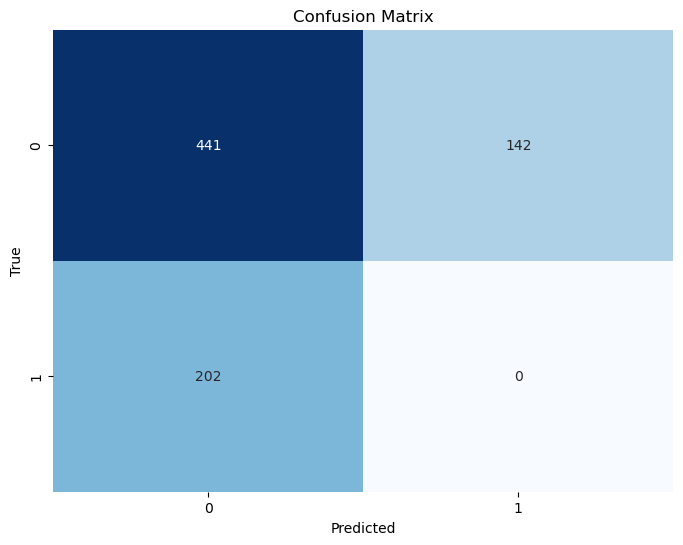

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       583
           1       0.00      0.00      0.00       202

    accuracy                           0.56       785
   macro avg       0.34      0.38      0.36       785
weighted avg       0.51      0.56      0.53       785



In [132]:
test_model(lr_model, X_val_umap, y_val)

### Random Forest

In [133]:
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial, X, y):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Create the Random Forest Classifier with the suggested hyperparameters
    seed = 42
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=seed)

    mcc_scorer = make_scorer(matthews_corrcoef)

    if trial.should_prune():
        raise optuna.TrialPruned()

    # Perform 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=mcc_scorer)

    # Return the mean MCC score as the objective value to be maximized
    return scores.mean()

In [134]:
def optimize_hyperparameters_rf(X, y):
    final_objective = lambda trial: objective_rf(trial, X, y)
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(final_objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

    best_params = study.best_params
    best_value = study.best_value

    print("Best Hyperparameters:", best_params)
    print("Best Value:", best_value)

    return best_params, best_value

In [135]:
def build_rf_model(X, y, best_params):
    seed = 42
    rf_model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=seed
    )

    rf_model.fit(X, y)
    
    return rf_model


In [136]:
rf_best_params, rf_best_value = optimize_hyperparameters_rf(X_train_umap, labels)

[I 2023-07-07 21:02:19,755] A new study created in memory with name: no-name-c4e153a8-072e-4862-ac19-b7e0ba4a9d46


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 21:02:27,096] Trial 0 finished with value: 0.5421801613718319 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5421801613718319.
[I 2023-07-07 21:03:05,999] Trial 4 finished with value: 0.5925636896207838 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.5925636896207838.
[I 2023-07-07 21:03:07,569] Trial 2 finished with value: 0.5876461434088824 and parameters: {'n_estimators': 600, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.5925636896207838.
[I 2023-07-07 21:03:10,165] Trial 3 finished with value: 0.5846102382613412 and parameters: {'n_estimators': 600, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.5925636896207838.
[I 2023-07-07 21:03:21,281] Trial 5 finished with value: 0.5715723958701264 and parameters: {

In [137]:
rf_model = build_rf_model(X_train_umap, labels, rf_best_params)
rf_model

RandomForestClassifier(max_depth=11, min_samples_leaf=4, min_samples_split=7,
                       n_estimators=600, random_state=42)

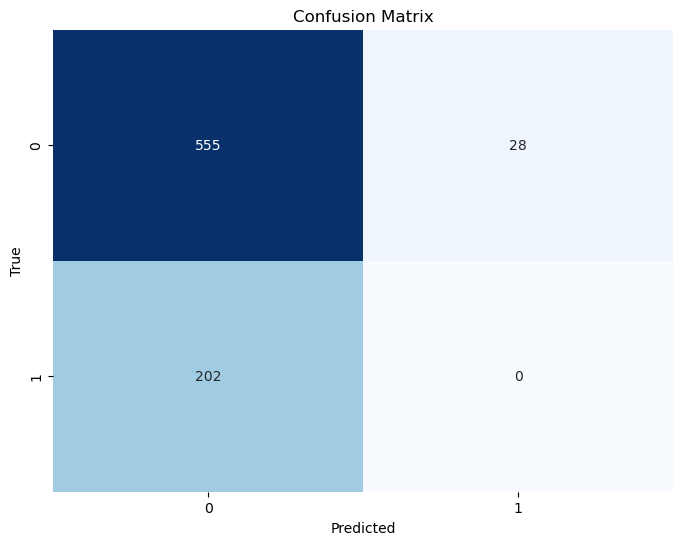

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       583
           1       0.00      0.00      0.00       202

    accuracy                           0.71       785
   macro avg       0.37      0.48      0.41       785
weighted avg       0.54      0.71      0.62       785



In [138]:
test_model(rf_model, X_val_umap, y_val)

### XGBoost

In [145]:
import xgboost as xgb

def objective_xgb(trial, X, y):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)

    # Create the XGBoost Classifier with the suggested hyperparameters
    seed = 42
    clf = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                            learning_rate=learning_rate, subsample=subsample,
                            colsample_bytree=colsample_bytree, random_state=seed)

    mcc_scorer = make_scorer(matthews_corrcoef)

    if trial.should_prune():
        raise optuna.TrialPruned()

    # Perform 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=mcc_scorer)

    # Return the mean MCC score as the objective value to be maximized
    return scores.mean()


In [140]:
def optimize_hyperparameters_xgb(X, y):
    final_objective = lambda trial: objective_xgb(trial, X, y)
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(final_objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

    best_params = study.best_params
    best_value = study.best_value

    print("Best Hyperparameters:", best_params)
    print("Best Value:", best_value)

    return best_params, best_value


In [143]:
def build_xgb_model(X, y, best_params):
    seed = 42
    xgb_model = xgb.XGBClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        random_state=seed
    )

    xgb_model.fit(X, y)
    
    return xgb_model

In [146]:
xgb_best_params, xgb_best_value = optimize_hyperparameters_xgb(X_train_umap, labels)

[I 2023-07-07 21:31:20,414] A new study created in memory with name: no-name-a6febd58-8e48-41d2-a73e-fa19b1727dba


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 21:31:22,144] Trial 0 finished with value: 0.45049453780056375 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.033870276979451934, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.45049453780056375.
[I 2023-07-07 21:31:29,204] Trial 1 finished with value: 0.4419919384033701 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.04332616453796048, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.45049453780056375.
[I 2023-07-07 21:31:29,317] Trial 4 finished with value: 0.40985045051996416 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.015421016722122672, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.45049453780056375.
[I 2023-07-07 21:31:31,137] Trial 5 finished with value: 0.25048672516087556 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.016773437910315516, 'subsample': 1.0, 'colsample_bytree': 0.5}.

In [147]:
xgb_model = build_xgb_model(X_train_umap, labels, xgb_best_params)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.016146833265381355,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

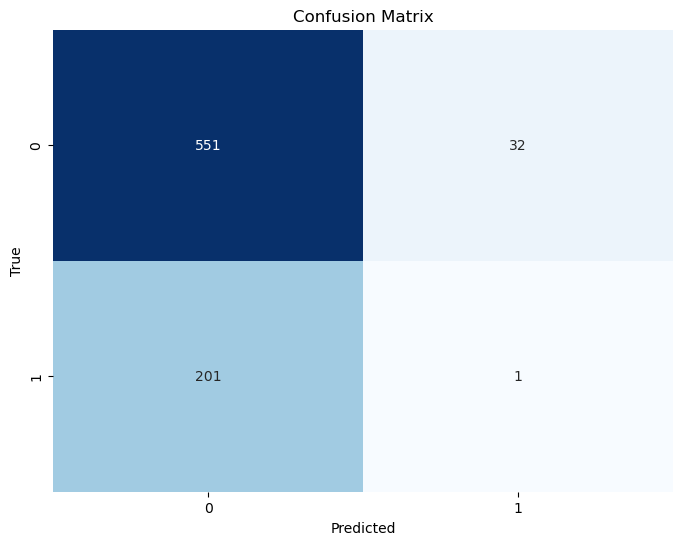

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       583
           1       0.03      0.00      0.01       202

    accuracy                           0.70       785
   macro avg       0.38      0.48      0.42       785
weighted avg       0.55      0.70      0.62       785



In [148]:
test_model(xgb_model, X_val_umap, y_val)

## Classic ML Approach 3

In this third and final approach 7 features were extracted from the images and no dimensionality reduction ensued. The same classifiers as before were tested, offering fine results for the complexity of the problem. More details can be found in the introduction of the Classic ML section above. 

### Feature extraction

In [170]:
from skimage.feature import multiblock_lbp
from scipy import stats

def get_feature_vector(images):
    kernel = np.ones((3,3),np.uint8)
    #print(kernel)
    var_vector = np.empty((len(images),1))
    lbp_vector = np.empty((len(images),1))
    mean_vector = np.empty((len(images),1))
    std_vector = np.empty((len(images),1))
    skew_vector = np.empty((len(images),1))
    kurto_vector = np.empty((len(images),1))
    entropy_vector = np.empty((len(images),1))
    #canny_vector = np.empty((len(images),img_size*img_size))
    #sobelX_vector = np.empty((len(images),img_size*img_size))
    #sobelY_vector = np.empty((len(images),img_size*img_size))

    for idx, image_path in enumerate(images):
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)  # Load the image from the image path
        x, bins = np.histogram(image, bins=255, density=False)
        var_vector[idx] = np.var(x)
        
        lbp = multiblock_lbp(image, 0, 0, 28, 28)
        lbp_vector[idx] = lbp
        
        mean_vector[idx] = np.mean(x)
        std_vector[idx] = np.std(x)
        skew_vector[idx] = stats.skew(x)
        kurto_vector[idx] = stats.kurtosis(x)
        entropy_vector[idx] = stats.entropy(x)
        
        #canny = cv2.Canny(image, 40, 200)
        #canny_vector[idx] = np.array(canny.flatten())
    
        #sobelX = cv2.Sobel(image, cv2.CV_8UC1, 1, 0, ksize=3)
        #sobelX_vector[idx] = np.array(sobelX.flatten())
        #sobelY = cv2.Sobel(image, cv2.CV_8UC1, 0, 1, ksize=3)
        #sobelY_vector[idx] = np.array(sobelY.flatten())
    
    feature_vector = np.empty((len(images),0))
    feature_vector = np.append(feature_vector, lbp_vector, axis=1)
    feature_vector = np.append(feature_vector, var_vector, axis=1)
    feature_vector = np.append(feature_vector, std_vector, axis=1)
    feature_vector = np.append(feature_vector, skew_vector, axis=1)
    feature_vector = np.append(feature_vector, kurto_vector, axis=1)
    feature_vector = np.append(feature_vector, entropy_vector, axis=1)
    #feature_vector = np.append(feature_vector, canny_vector, axis=1)
    #feature_vector = np.append(feature_vector, sobelX_vector, axis=1)
    #feature_vector = np.append(feature_vector, sobelY_vector, axis=1)
    
    return feature_vector



In [172]:
x_train = get_feature_vector(train_data['image'])
x_val = get_feature_vector(val_data['image'])

In [175]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.fit_transform(x_val)

In [176]:
from sklearn.utils import shuffle

y_train = train_data['label']
x_train, y_train = shuffle(x_train,y_train)

In [180]:
y_val = val_data['label']
x_val, y_val = shuffle(x_val,y_val)

#### SVM

In [196]:
svm_best_params, svm_best_value = optimize_hyperparameters(x_train, y_train)

[I 2023-07-07 22:51:03,102] A new study created in memory with name: no-name-4171abbf-c537-4fa1-9f16-a4f6fe8c5b69


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 22:51:04,585] Trial 2 finished with value: 0.6804729597193714 and parameters: {'c_svm': 0.03130318018962478, 'gamma_svm': 0.037693904900396376}. Best is trial 2 with value: 0.6804729597193714.
[I 2023-07-07 22:51:04,595] Trial 3 finished with value: 0.6874585379701119 and parameters: {'c_svm': 0.22157534390920172, 'gamma_svm': 0.3997481755366909}. Best is trial 3 with value: 0.6874585379701119.
[I 2023-07-07 22:51:04,821] Trial 1 finished with value: 0.6882868806318678 and parameters: {'c_svm': 0.7879171837570844, 'gamma_svm': 0.02486629519701479}. Best is trial 1 with value: 0.6882868806318678.
[I 2023-07-07 22:51:04,874] Trial 0 finished with value: 0.6123723205145322 and parameters: {'c_svm': 0.0034049708792478948, 'gamma_svm': 0.05805695150568505}. Best is trial 1 with value: 0.6882868806318678.
[I 2023-07-07 22:51:06,341] Trial 4 finished with value: 0.683459805832904 and parameters: {'c_svm': 0.04403687909267078, 'gamma_svm': 0.025925263067405373}. Best is trial 1 w

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2023-07-07 22:51:09,512] Trial 12 finished with value: 0.6875923508994312 and parameters: {'c_svm': 0.47664637920059105, 'gamma_svm': 0.003783150430091643}. Best is trial 10 with value: 0.6888035142338172.
[I 2023-07-07 22:51:09,986] Trial 14 finished with value: 0.6927587570384234 and parameters: {'c_svm': 0.0851784144609304, 'gamma_svm': 0.32751892343095956}. Best is trial 14 with value: 0.6927587570384234.
[I 2023-07-07 22:51:10,026] Trial 13 finished with value: 0.6882868806318678 and parameters: {'c_svm': 0.9390568078522407, 'gamma_svm': 0.0014457289454337821}. Best is trial 14 with value: 0.6927587570384234.
[I 2023-07-07 22:51:10,341] Trial 15 finished with value: 0.6906371970410962 and parameters: {'c_svm': 0.09775865309072154, 'gamma_svm': 0.7863796070595696}. Best is trial 14 with value: 0.6927587570384234.
[I 2023-07-07 22:51:10,963] Trial 16 finished with value: 0.6900449367761595 and parameters: {'c_svm': 0.09973293072422389, 'gamma_svm': 0.9007609980294025}. Best is tr

In [197]:
svm_model = build_svm_model(x_train, y_train, svm_best_params)
svm_model

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.0851784144609304, gamma=0.32751892343095956, kernel='linear',
    max_iter=1000, random_state=42)

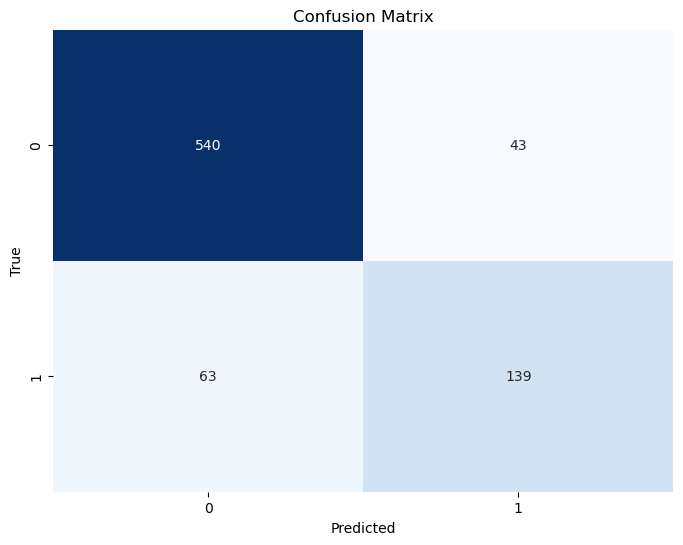

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       583
           1       0.76      0.69      0.72       202

    accuracy                           0.86       785
   macro avg       0.83      0.81      0.82       785
weighted avg       0.86      0.86      0.86       785



In [198]:
test_model(svm_model, x_val, y_val)

#### Logistic Regression

In [182]:
lr_best_params, lr_best_value = optimize_hyperparameters_lr(x_train, y_train)

[I 2023-07-07 22:06:12,306] A new study created in memory with name: no-name-79297bd2-ed45-4954-9118-44f87e9ee7a1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 22:06:12,582] Trial 0 finished with value: 0.5002791693667722 and parameters: {'c_lr': 0.0015789271737084646}. Best is trial 0 with value: 0.5002791693667722.
[I 2023-07-07 22:06:12,642] Trial 2 finished with value: 0.5839169468029601 and parameters: {'c_lr': 0.005453324080080342}. Best is trial 2 with value: 0.5839169468029601.
[I 2023-07-07 22:06:12,804] Trial 3 finished with value: 0.67536669442868 and parameters: {'c_lr': 0.9864468069942449}. Best is trial 3 with value: 0.67536669442868.
[I 2023-07-07 22:06:12,859] Trial 4 finished with value: 0.493273101471841 and parameters: {'c_lr': 0.0015217456687837804}. Best is trial 3 with value: 0.67536669442868.
[I 2023-07-07 22:06:12,897] Trial 1 finished with value: 0.67536669442868 and parameters: {'c_lr': 0.9388521805270268}. Best is trial 3 with value: 0.67536669442868.
[I 2023-07-07 22:06:13,113] Trial 5 finished with value: 0.67536669442868 and parameters: {'c_lr': 0.8515190043721373}. Best is trial 3 with value: 0.675

In [183]:
lr_model = build_lr_model(x_train, y_train, lr_best_params)
lr_model

LogisticRegression(C=0.5516418289011472, max_iter=1000, random_state=42)

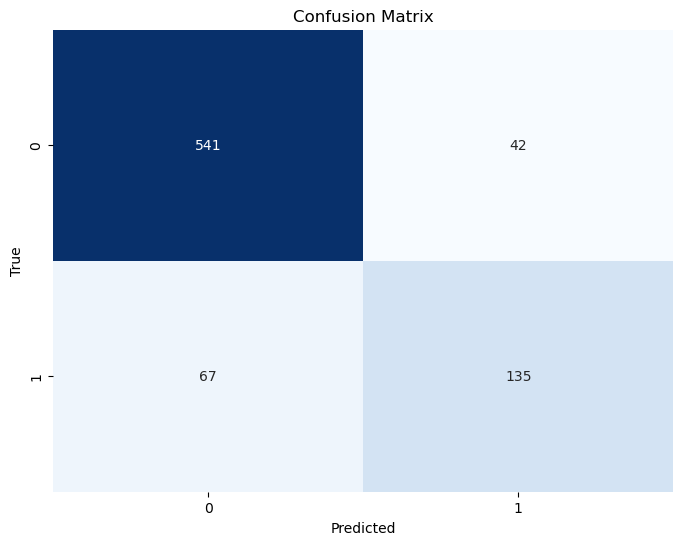

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       583
           1       0.76      0.67      0.71       202

    accuracy                           0.86       785
   macro avg       0.83      0.80      0.81       785
weighted avg       0.86      0.86      0.86       785



In [184]:
test_model(lr_model, x_val, y_val)

#### Random Forest

In [185]:
rf_best_params, rf_best_value = optimize_hyperparameters_rf(x_train, y_train)

[I 2023-07-07 22:09:04,069] A new study created in memory with name: no-name-15ca3eb5-bba2-40e2-b5d0-aa740b6bd2a0


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 22:09:48,915] Trial 3 finished with value: 0.6968698696730942 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.6968698696730942.
[I 2023-07-07 22:09:55,993] Trial 1 finished with value: 0.6917426844586345 and parameters: {'n_estimators': 700, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.6968698696730942.
[I 2023-07-07 22:10:07,711] Trial 4 finished with value: 0.6987526199699541 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.6987526199699541.
[I 2023-07-07 22:10:29,361] Trial 0 finished with value: 0.6918236459958891 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.6987526199699541.
[I 2023-07-07 22:10:30,743] Trial 2 finished with value: 0.700992378098554 and parameters: 

In [186]:
rf_model = build_rf_model(x_train, y_train, rf_best_params)
rf_model

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=700, random_state=42)

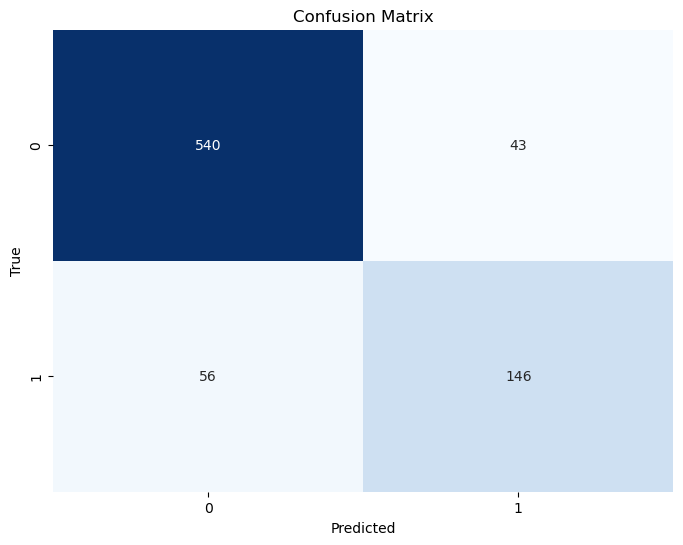

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       583
           1       0.77      0.72      0.75       202

    accuracy                           0.87       785
   macro avg       0.84      0.82      0.83       785
weighted avg       0.87      0.87      0.87       785



In [187]:
test_model(rf_model, x_val, y_val)

In [188]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
    sorted_feature_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

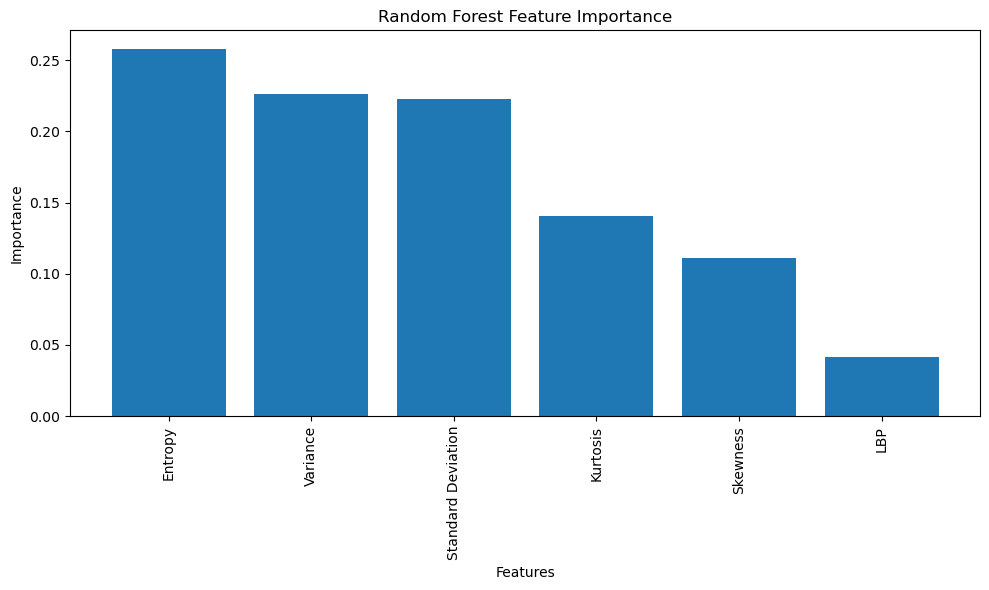

In [190]:
feature_names = ['LBP', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis', 'Entropy']

plot_feature_importance(rf_model, feature_names)

#### XGBoost

In [191]:
xgb_best_params, xgb_best_value = optimize_hyperparameters_xgb(x_train, y_train)

[I 2023-07-07 22:40:38,171] A new study created in memory with name: no-name-f8ed1cba-807f-4c3b-a4fc-4ebcb2ffcf46


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-07 22:40:43,999] Trial 3 finished with value: 0.696591342863755 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.015420702161044918, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 3 with value: 0.696591342863755.
[I 2023-07-07 22:40:46,770] Trial 2 finished with value: 0.6965703378173773 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.029109081061943425, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.696591342863755.
[I 2023-07-07 22:40:49,653] Trial 1 finished with value: 0.7023811726009704 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.049839319670732934, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023811726009704.
[I 2023-07-07 22:40:57,641] Trial 6 finished with value: 0.6934221620991898 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.016638085519624875, 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is

In [192]:
xgb_model = build_xgb_model(x_train, y_train, xgb_best_params)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03636153658331241,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

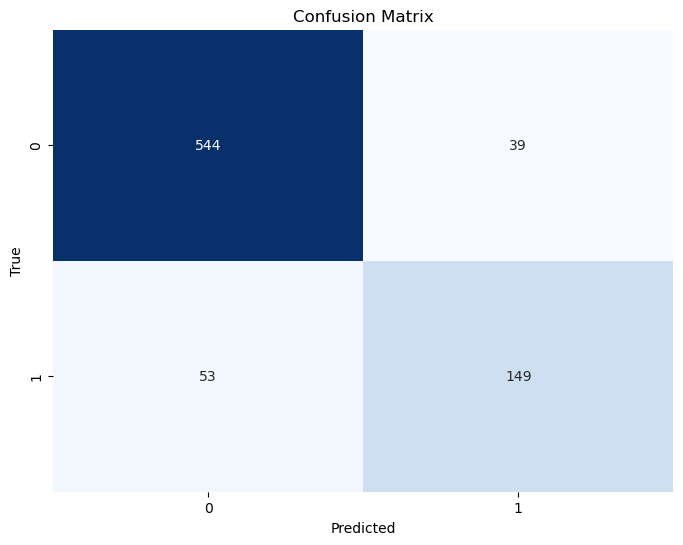

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       583
           1       0.79      0.74      0.76       202

    accuracy                           0.88       785
   macro avg       0.85      0.84      0.84       785
weighted avg       0.88      0.88      0.88       785



In [193]:
test_model(xgb_model, x_val, y_val)

### Model testing on held-out test set

The winner of the above comparison on the validation set was XGBoost with an MCC score of 0.7119. Therefore, this model was trained first on the held-out test set to validate its generalization ability on unseen data. Interestingly enough, SVM seemed to offer a better generalization ability judging by the amount of correcly classified instances.

In [200]:
x_test = get_feature_vector(test_data['image'])
x_test = sc.fit_transform(x_test)

y_test = test_data['label']
x_test, y_test = shuffle(x_test, y_test)

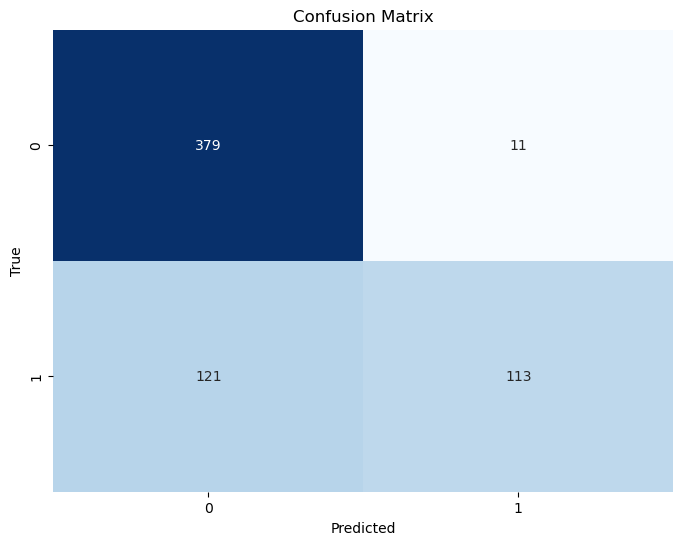

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       390
           1       0.91      0.48      0.63       234

    accuracy                           0.79       624
   macro avg       0.83      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



In [201]:
test_model(xgb_model, x_test, y_test)

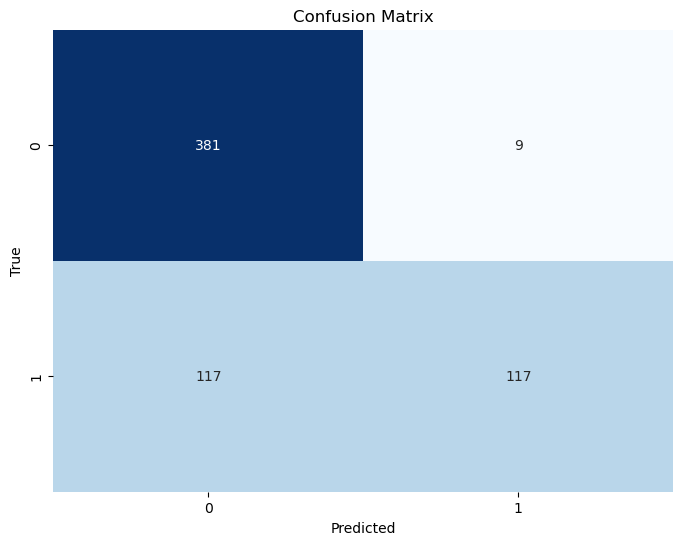

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       390
           1       0.93      0.50      0.65       234

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



In [203]:
test_model(rf_model, x_test, y_test)

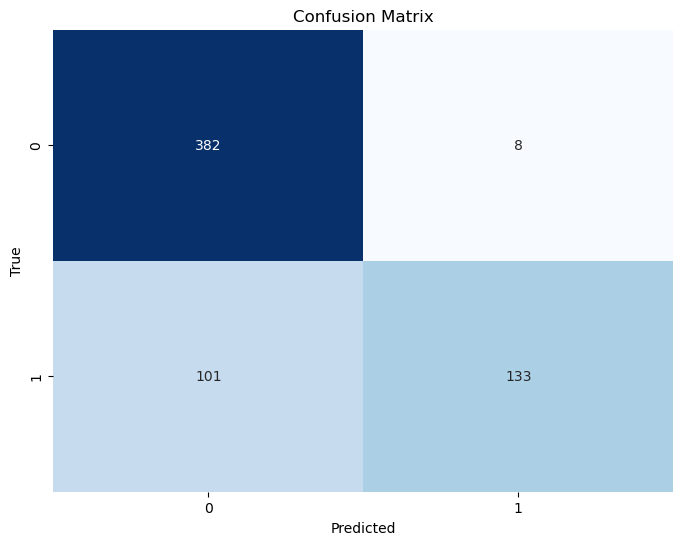

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       390
           1       0.94      0.57      0.71       234

    accuracy                           0.83       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624



In [204]:
test_model(lr_model, x_test, y_test)

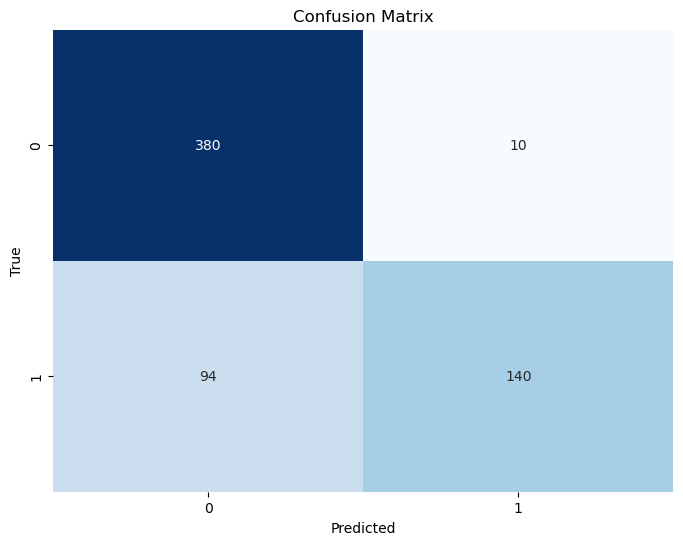

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       390
           1       0.93      0.60      0.73       234

    accuracy                           0.83       624
   macro avg       0.87      0.79      0.80       624
weighted avg       0.85      0.83      0.82       624



In [205]:
test_model(svm_model, x_test, y_test)

-------------------

# Deep Learning Methods

The classification was also performed with Deep Learning methods.Two pretrained models (DenseNet169, MobilenetV2) which are based on CNNs and thus appropriate for image classification were stacked together, in an attempt to create a model with enhanced performance. The Keras library was used for all purposes. The model was trained in batches, using  datagenerator, to avoid memory issues due to the dataset size. For the training process the PR-AUC metric was chosen for evaluation, as it is a suitable metric for class imbalance. The accuracy metric was avoided, because in such cases of class imbalance where the negative class is bigger, it is very easy for the model to give pseudo-optimistic results by predicting most of the times the most abundant class. 

The stacked model proved to be superior to all previously tested classic ML methods, but this is to be expected per the CNN nature of the individual models and the fact that they were pretrained with more data. More in detail, during training and evaluation with the validation set the model achieved an excellent score of approximately 0.95 on the PR-AUC, results that could have been indicative of overfitting, if not for the equally good performance that the model achieved on the unseen training set. The macro averages for Precision, Recall and F1-score were respectively 0.92, 0.89, 0.90. Accuracy was at 0.91. Finally, except for only 50 instances (10 for the normal, 40 for the pneumonia class) all others were correctly classified. It is important to highlight the fact that only a few instances of the positive class were misclassified. As mentioned earlier, this class is in a way the most important one to approximate correctly, because of the adverse effect a misclassification could have on the therapeutic approach of a patient. 

Neural Networks surpassed the classic ML methods, but this was to be expected as such models have usually a greater ability at capturing complex relations between the data. On the other hand, classic ML models offer a lot more interpretability, which may be more important in a clinical setting.

In [ ]:
#from keras.layers.merge import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf

## Data preprocessing

Data augmentation is used to generate images of the train, val and test sets.

In [ ]:
def create_data_generator(data, datagen, img_width, img_height, batch_size):
    # Convert PosixPath objects to string paths
    data['image'] = data['image'].apply(str)

    # Convert label values to strings
    data['label'] = data['label'].astype(str)

    generator = datagen.flow_from_dataframe(
        dataframe=data,
        x_col='image',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    return generator


In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
    plt.show()


In [ ]:

datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by 20% of the image width
    height_shift_range=0.2,     # Randomly shift images vertically by 20% of the image height
    shear_range=0.2,            # Apply random shear transformations
    zoom_range=0.2,             # Apply random zoom transformations
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill any newly created pixels after rotation or shifting
)


In [ ]:
img_width, img_height = 224, 224
batch_size = 16

train_generator = create_data_generator(train_data, datagen, img_width, img_height, batch_size)

Found 5216 validated image filenames belonging to 2 classes.


In [ ]:
img_width, img_height = 224, 224
batch_size = 16

val_generator = create_data_generator(val_data, datagen, img_width, img_height, batch_size)

Found 16 validated image filenames belonging to 2 classes.


In [ ]:
img_width, img_height = 224, 224
batch_size = 16

test_generator = create_data_generator(test_data, datagen, img_width, img_height, batch_size)

Found 624 validated image filenames belonging to 2 classes.


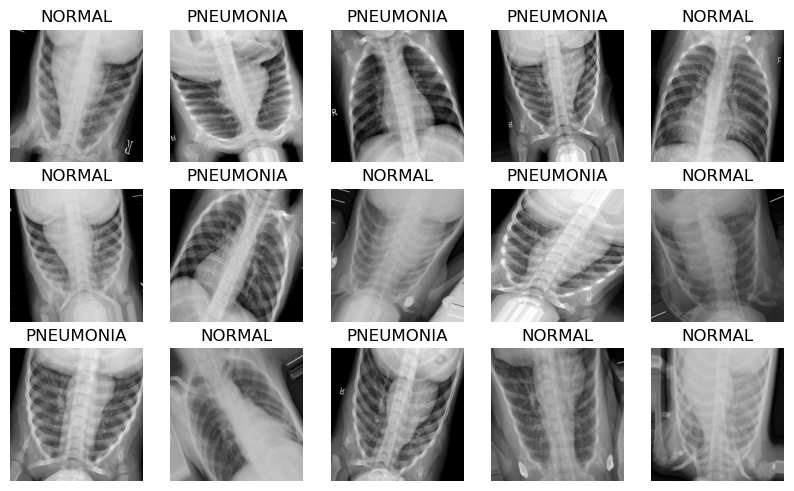

In [ ]:
image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch)


## Model creation

The model that was created used the pretrained DenseNet169 and MobilenetV2 models and stacked the last pre-trained layers using merge class.

In [ ]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))

In [ ]:
densenet_path = '../input/pretrained-keras-models/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5'

if os.path.exists(densenet_path):
    densenet_base = DenseNet169(weights=densenet_path, input_shape=input_shape, include_top=False)
else:
    densenet_base = DenseNet169(weights='imagenet', input_shape=input_shape, include_top=False)

In [ ]:
mobilenet_path = '../input/pretrained-keras-models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

if os.path.exists(mobilenet_path):
    mobilenet_base = MobileNetV2(weights=mobilenet_path, input_shape=input_shape, include_top=False)
else:
    mobilenet_base = MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

In [ ]:
for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False

In [ ]:
model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet])

In [ ]:
x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)

stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

In [ ]:
optimizer = Adam(lr=0.0001)
metric=tf.keras.metrics.AUC(curve='PR') 
stacked_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metric)

In [ ]:

EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

In [ ]:
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

## Model training

In [ ]:
num_train_samples = train_data.shape[0]
num_validation_samples = val_data.shape[0]
num_test_samples = test_data.shape[0]
epochs = 20  
batch_size = 16

In [ ]:
history = stacked_model.fit(train_generator,
                              steps_per_epoch = num_train_samples // batch_size,
                              epochs = 20,
                              validation_data = val_generator,
                              callbacks=[EarlyStopping, rlr])

Epoch 1/20
326/326 [==============================] - 149s 391ms/step - loss: 0.2366 - auc: 0.8821 - val_loss: 0.3513 - val_auc: 1.0000 - lr: 0.0010
Epoch 2/20
326/326 [==============================] - 104s 319ms/step - loss: 0.1883 - auc: 0.9232 - val_loss: 0.6784 - val_auc: 0.9108 - lr: 0.0010
Epoch 3/20
326/326 [==============================] - 105s 323ms/step - loss: 0.1572 - auc: 0.9386 - val_loss: 0.3309 - val_auc: 0.9853 - lr: 0.0010
Epoch 4/20
326/326 [==============================] - 102s 314ms/step - loss: 0.1462 - auc: 0.9454 - val_loss: 0.3621 - val_auc: 0.9853 - lr: 0.0010
Epoch 5/20
326/326 [==============================] - 103s 317ms/step - loss: 0.1377 - auc: 0.9514 - val_loss: 0.4640 - val_auc: 0.9493 - lr: 0.0010
Epoch 6/20
326/326 [==============================] - 103s 315ms/step - loss: 0.1383 - auc: 0.9531 - val_loss: 0.3691 - val_auc: 1.0000 - lr: 0.0010
Epoch 7/20
326/326 [==============================] - 102s 314ms/step - loss: 0.1223 - auc: 0.9648 - val_l

In [ ]:
import pickle

# Save the model
stacked_model.save("stacked_model.h5")

# Save the history
with open("history.pickle", "wb") as file:
    pickle.dump(history.history, file)


## Model testing

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

def process_image(image):
    image = image / 255
    image = cv2.resize(image, (224, 224))
    return image

def predict(image_path, model):
    im = cv2.imread(str(image_path))  # Convert PosixPath to string
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis=0)

    ps = model.predict(processed_test_image, verbose=0)
    return ps

def testing(model, test_df):
    base_pred = []
    for image in test_df['image']:
        base_pred.append(predict(image, model)[0][0])

    final_base_pred = np.where(np.array(base_pred) > 0.5, 1, 0)
    actual_label = test_df['label'].astype(int)  # Convert labels to integers

    print(classification_report(actual_label, final_base_pred))
    matrix = confusion_matrix(actual_label, final_base_pred)
    sb.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.show()


              precision    recall  f1-score   support

           0       0.89      0.97      0.93       390
           1       0.95      0.81      0.87       234

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



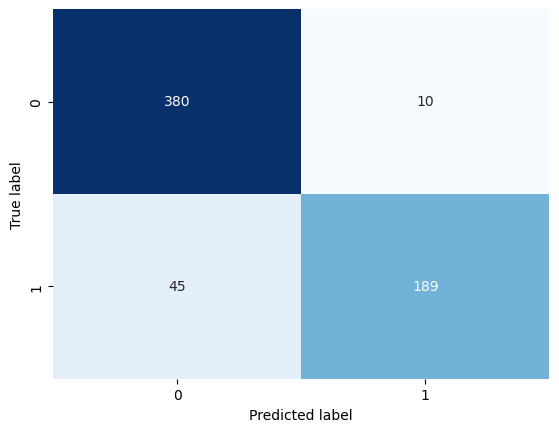

In [ ]:
testing(stacked_model, test_data)

** End of notebook **